# Lecture 14: stochastic processes, uncertainty and sensitivity

## Stochastic processes

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('DonPedroData.csv')
df['date'] = pd.to_datetime(df.DATE, format='%m/%d/%y')
df['year'] = df.date.dt.year
df['dayofyear'] = df.date.dt.dayofyear
df.head()

,STATION_ID,DURATION,DATE,INFLOW_cfs,OUTFLOW_cfs,STORAGE_af,date,year,dayofyear
0,DNP,D,1/1/94,213.0,213.0,NaN,1994-01-01,1994,1
1,DNP,D,1/2/94,213.0,213.0,1586937.0,1994-01-02,1994,2
2,DNP,D,1/3/94,656.0,204.0,1584792.0,1994-01-03,1994,3
3,DNP,D,1/4/94,656.0,204.0,1584792.0,1994-01-04,1994,4
4,DNP,D,1/5/94,NaN,NaN,1583721.0,1994-01-05,1994,5


             INFLOW_cfs
date                   
1994-01-31  1257.750000
1994-02-28  1734.380952
1994-03-31  5399.320000
1994-04-30  4112.160000
1994-05-31  6477.222222
...                 ...
2023-01-31   399.733333
2023-02-28   375.821429
2023-03-31   895.733333
2023-04-30  2731.166667
2023-05-31  4104.103448

[353 rows x 1 columns]
             t       t+1       t+2       t+3       t+4       t+5       t+6  \
t     1.000000  0.738038  0.472593  0.244283  0.072488 -0.113460 -0.229397   
t+1   0.738038  1.000000  0.738240  0.473925  0.245805  0.073800 -0.112342   
t+2   0.472593  0.738240  1.000000  0.738713  0.474482  0.246181  0.074059   
t+3   0.244283  0.473925  0.738713  1.000000  0.738434  0.473871  0.245270   
t+4   0.072488  0.245805  0.474482  0.738434  1.000000  0.738019  0.473010   
t+5  -0.113460  0.073800  0.246181  0.473871  0.738019  1.000000  0.737596   
t+6  -0.229397 -0.112342  0.074059  0.245270  0.473010  0.737596  1.000000   
t+7  -0.235797 -0.228543 -0.112234  0.07

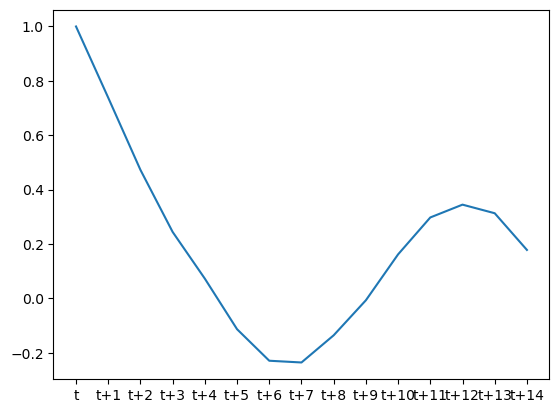

In [194]:
from statsmodels.graphics.tsaplots import plot_acf

data = df[['date', 'INFLOW_cfs']]
data = data.set_index('date')

dfmonth = data.groupby(pd.Grouper(freq='ME')).mean()
dfyear = data.groupby(pd.Grouper(freq='YE')).mean()

dfmonth_lags = pd.concat([dfmonth, dfmonth.shift(1),
                       dfmonth.shift(2), dfmonth.shift(3), dfmonth.shift(4),
                          dfmonth.shift(5), dfmonth.shift(6), dfmonth.shift(7),
                          dfmonth.shift(8), dfmonth.shift(9), dfmonth.shift(10),
                          dfmonth.shift(11), dfmonth.shift(12), dfmonth.shift(13),
                          dfmonth.shift(14)], axis=1)

dfmonth_lags.columns = ['t', 't+1', 't+2', 't+3', 't+4',
                        't+5', 't+6', 't+7', 't+8', 't+9',
                        't+10', 't+11', 't+12', 't+13', 't+14']

print(dfmonth)

ac = dfmonth_lags.corr()

print(ac)

plt.plot(ac.iloc[0,:])

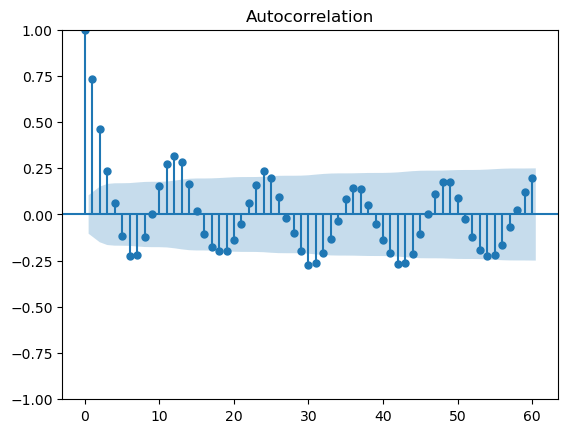

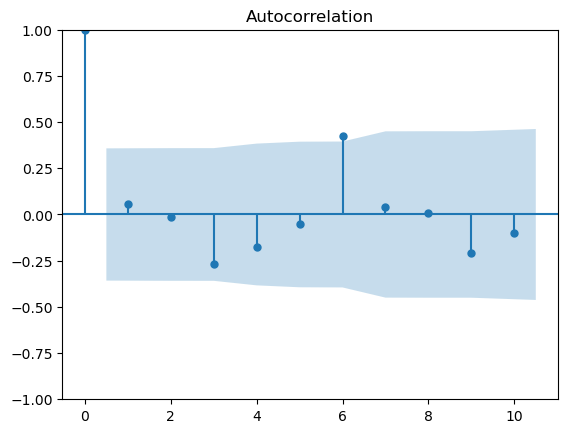

In [195]:
# Plot autocorrelation
plot_acf(dfmonth, lags=60, alpha=0.05, missing='drop', title='Autocorrelation');
plot_acf(dfyear, lags=10, alpha=0.05, missing='drop', title='Autocorrelation');


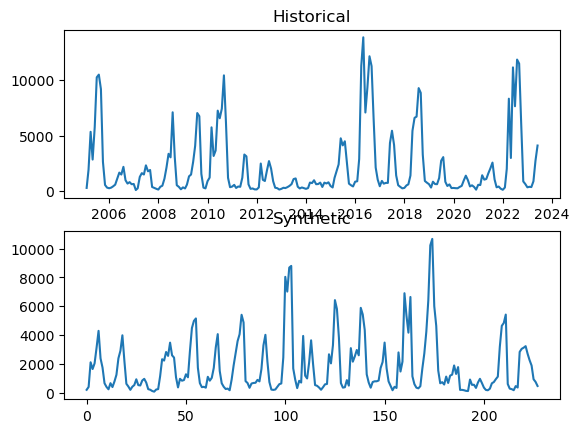

In [199]:
#Thomas-Fiering
#code by Jon Herman
#https://github.com/jdherman/eci273/blob/main/L08-synthetic-streamflow.ipynb

def get_monthly_stats(x):
    '''calculate monthly mean, std. dev., and lag-1 autocorrelation
    from historical data x. Assumes each month is lognormally distributed.'''
    
    x = np.log(x)
    N = len(x)
    mu = np.zeros(12)
    sigma = np.zeros(12)
    rho = np.zeros(12) # varies the autocorrelation
    
    for m in range(12): # loops over all 12 months
        mu[m] = x[m::12].mean() # m::12 is array slicing, picking out every 12; start in month m, go to the end in steps of 12
        sigma[m] = x[m::12].std()
        x1 = x[m:N-1:12]
        x2 = x[m+1::12]
        rho[m] = np.corrcoef(x1,x2)[0,1] # index the matrix
    
    return mu,sigma,rho # log space


# sets up the synthetic data generation
def thomasfiering_monthly(mu, sigma, rho, N_years):
    '''Lag-1 model. use historical monthly statistics to generate 
    a synthetic sequence of N years'''
    
    Q = np.zeros(N_years*12) # initialize
    Q[0] = np.random.normal(mu[0],sigma[0],1)[0]
    
    for y in range(N_years):
        for m in range(12):
            i = 12*y + m # index
            
            if i > 0:
                Z = np.random.standard_normal()
                Q[i] = mu[m] + rho[m-1]*(Q[i-1] - mu[m-1]) + Z*sigma[m]*np.sqrt(1-rho[m-1]**2)
    
    return np.exp(Q) # real space 



df = df.loc[df.year>2004]
data = df[['date', 'INFLOW_cfs']]
data = data.set_index('date')
dfmonth = data.groupby(pd.Grouper(freq='ME')).mean()

Q = dfmonth.INFLOW_cfs

# print(dfmonth)

mu,sigma,rho = get_monthly_stats(Q)
Q_synthetic = thomasfiering_monthly(mu, sigma, rho, N_years=19)

# a,b,c = get_monthly_stats(Q_synthetic)

# for m in range(12):
#     print('Month %d means: %f, %f' % (m,mu[m],a[m]))
# for m in range(12):
#     print('Month %d stdev: %f, %f' % (m,sigma[m],b[m]))
# for m in range(12):
#     print('Month %d rho: %f, %f' % (m,rho[m],c[m]))
    
plt.subplot(2,1,1)
plt.plot(Q)
plt.title('Historical')
plt.subplot(2,1,2)
plt.title('Synthetic')
plt.plot(Q_synthetic)
plt.show()